### Tuning hyperparameters via grid search

The grid search approach is quite simple: it’s a brute-force exhaustive search paradigm where we spec-
ify a list of values for dierent hyperparameters, and the computer evaluates the model performance
for each combination to obtain the optimal combination of values from this set:

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',header = None)
from sklearn.preprocessing import LabelEncoder
X = df.iloc[:,2:].values
Y = df.iloc[:,1].values
le = LabelEncoder()
Y = le.fit_transform(Y)
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.3,stratify = Y,random_state = 1)

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1,1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,'svc__kernel': ['linear']},{'svc__C': param_range,'svc__gamma': param_range,'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='accuracy',cv=10,refit=True,n_jobs=-1)
gs = gs.fit(X_train, Y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9924358974358973
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


Using the preceding code, we initialized a GridSearchCV object from the sklearn.model_selection
module to train and tune an SVM pipeline. We set the param_grid parameter of GridSearchCV to a list
of dictionaries to specify the parameters that we’d want to tune. For the linear SVM, we only evaluated
the inverse regularization parameter, C; for the radial basis function (RBF) kernel SVM, we tuned both
the svc__C and svc__gamma parameters. Note that the svc__gamma parameter is specic to kernel SVMs.
GridSearchCV uses k-fold cross-validation for comparing models trained with dierent hyperparam-
eter settings. Via the cv=10 setting, it will carry out 10-fold cross-validation and compute the average
accuracy (via scoring='accuracy' ) across these 10-folds to assess the model performance. We set
n_jobs=-1 so that GridSearchCV can use all our processing cores to speed up the grid search by tting
models to the dierent folds in parallel, but if your machine has problems with this setting, you may
change this setting to n_jobs=None for single processing.
Aer we used the training data to perform the grid search, we obtained the score of the best-perform-
ing model via the best_score_ attribute and looked at its parameters, which can be accessed via the
best_params_ attribute. In this particular case, the RBF kernel SVM model with svc__C = 100.0
yielded the best k-fold cross-validation accuracy: 98.5 percent.

Finally, we use the independent test dataset to estimate the performance of the best-selected model,
which is available via the best_estimator_ attribute of the GridSearchCV object:

In [4]:
clf = gs.best_estimator_
clf.fit(X_train, Y_train)
print(f'Test accuracy: {clf.score(X_test, Y_test):.3f}')

Test accuracy: 0.959


### Exploring hyperparameter configurations more widely with randomized search

Since grid search is an exhaustive search, it is guaranteed to nd the optimal hyperparameter congu-
ration if it is contained in the user-specied parameter grid. However, specifying large hyperparameter
grids makes grid search very expensive in practice. An alternative approach for sampling dierent
parameter combinations is randomized search. In randomized search, we draw hyperparameter
congurations randomly from distributions (or discrete sets). In contrast to grid search, randomized
search does not do an exhaustive search over the hyperparameter space. Still, it allows us to explore a
wider range of hyperparameter value settings in a more cost- and time-eective manner.

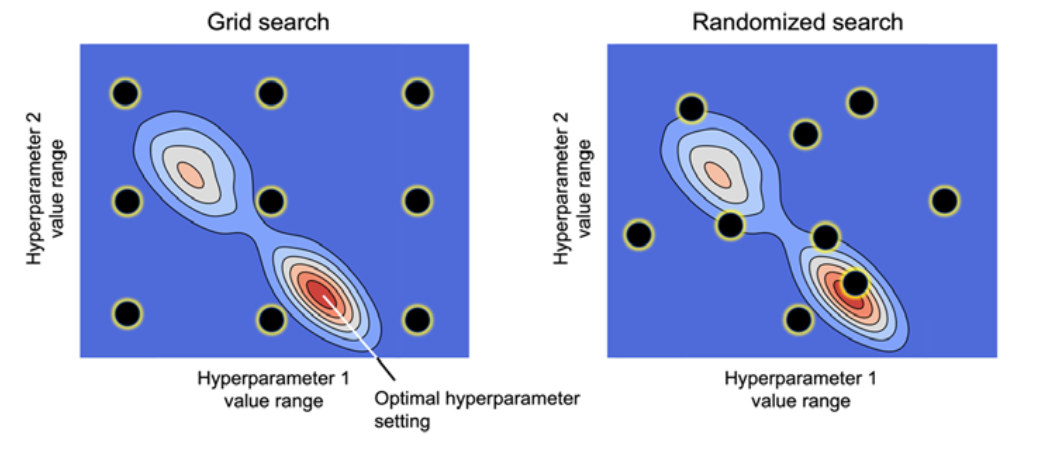

In [5]:
from sklearn.model_selection import RandomizedSearchCV
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_grid = [{'svc__C': param_range,
    'svc__kernel': ['linear']},
    {'svc__C': param_range,
    'svc__gamma': param_range,
    'svc__kernel': ['rbf']}]
rs = RandomizedSearchCV(estimator=pipe_svc,param_distributions=param_grid,scoring='accuracy',refit=True,n_iter=20,cv=10,random_state=1,n_jobs=-1)
rs = rs.fit(X_train, Y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9799358974358974
{'svc__kernel': 'rbf', 'svc__gamma': 0.1, 'svc__C': 100.0}


### Reading a confusion matrix

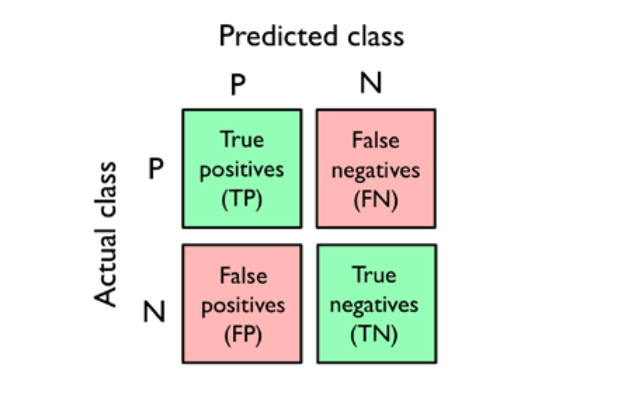

In [6]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, Y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=Y_test, y_pred=y_pred)
print(confmat)

[[105   2]
 [  6  58]]


In [7]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import matthews_corrcoef
pre_val = precision_score(y_true=Y_test, y_pred=y_pred)
print(f'Precision: {pre_val:.3f}')
rec_val = recall_score(y_true=Y_test, y_pred=y_pred)
print(f'Recall: {rec_val:.3f}')
f1_val = f1_score(y_true=Y_test, y_pred=y_pred)
print(f'F1: {f1_val:.3f}')
mcc_val = matthews_corrcoef(y_true=Y_test, y_pred=y_pred)
print(f'MCC: {mcc_val:.3f}')

Precision: 0.967
Recall: 0.906
F1: 0.935
MCC: 0.900


### Plotting a receiver operating characteristic

Receiver operating characteristic (ROC) graphs are useful tools to select models for classication
based on their performance with respect to the FPR and TPR, which are computed by shiing the
decision threshold of the classier. The diagonal of a ROC graph can be interpreted as random guessing,
and classication models that fall below the diagonal are considered as worse than random guessing.
A perfect classier would fall into the top-le corner of the graph with a TPR of 1 and an FPR of 0.
Based on the ROC curve, we can then compute the so-called ROC area under the curve (ROC AUC) to
characterize the performance of a classication model.

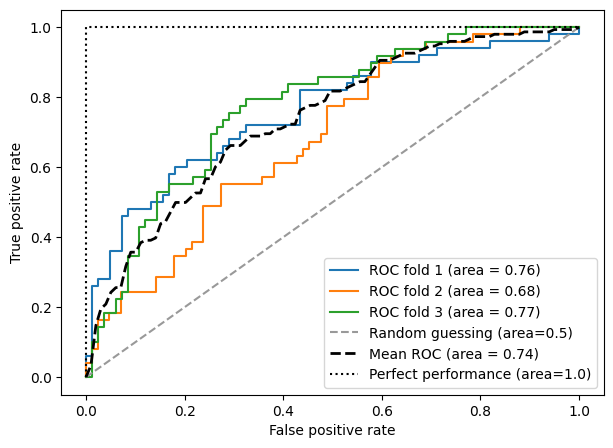

In [13]:
from sklearn.metrics import roc_curve, auc
from numpy import interp
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import  matplotlib.pyplot as plt
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(penalty='l2', random_state=1,solver='lbfgs', C=100.0))
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3).split(X_train, Y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
  probas = pipe_lr.fit(
  X_train2[train],
  Y_train[train]
  ).predict_proba(X_train2[test])
  fpr, tpr, thresholds = roc_curve(Y_train[test],
  probas[:, 1],
  pos_label=1)
  mean_tpr += interp(mean_fpr, fpr, tpr)
  mean_tpr[0] = 0.0
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr,
  tpr,
  label=f'ROC fold {i+1} (area = {roc_auc:.2f})')
plt.plot([0, 1],
[0, 1],
linestyle='--',
color=(0.6, 0.6, 0.6),
label='Random guessing (area=0.5)')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1],
[0, 1, 1],
linestyle=':',
color='black',
label='Perfect performance (area=1.0)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()

### Scoring metrics for multiclass classification

The scoring metrics that we’ve discussed so far are specic to binary classication systems. However,
scikit-learn also implements macro and micro averaging methods to extend those scoring metrics
to multiclass problems via one-vs.-all (OvA) classication. The micro-average is calculated from the
individual TPs, TNs, FPs, and FNs of the system. For example, the micro-average of the precision score
in a k-class system can be calculated as follows:

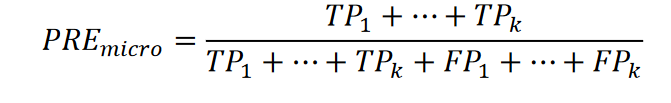

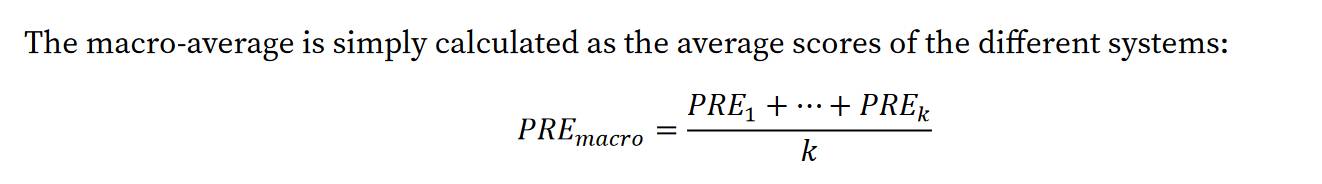

Micro-averaging is useful if we want to weight each instance or prediction equally, whereas macro-av-
eraging weights all classes equally to evaluate the overall performance of a classier with regard to
the most frequent class labels.
If we are using binary performance metrics to evaluate multiclass classication models in scikit-learn,
a normalized or weighted variant of the macro-average is used by default. The weighted macro-av-
erage is calculated by weighting the score of each class label by the number of true instances when
calculating the average. The weighted macro-average is useful if we are dealing with class imbalances,
that is, dierent numbers of instances for each label.
While the weighted macro-average is the default for multiclass problems in scikit-learn, we can specify
the averaging method via the average parameter inside the dierent scoring functions that we import
from the sklearn.metrics module, for example, the precision_score or make_scorer functions:

In [15]:
from sklearn.metrics import make_scorer
pre_scorer = make_scorer(score_func=precision_score,
  pos_label=1,
  greater_is_better=True,
  average='micro')

### Dealing with class imbalance

We’ve mentioned class imbalances several times throughout this chapter, and yet we haven’t actually
discussed how to deal with such scenarios appropriately if they occur. Class imbalance is a quite com-
mon problem when working with real-world data—examples from one class or multiple classes are
over-represented in a dataset. We can think of several domains where this may occur, such as spam
ltering, fraud detection, or screening for diseases.
Imagine that the Breast Cancer Wisconsin dataset that we’ve been working with in this chapter con-
sisted of 90 percent healthy patients. In this case, we could achieve 90 percent accuracy on the test
dataset by just predicting the majority class (benign tumor) for all examples, without the help of a
supervised machine learning algorithm. Thus, training a model on such a dataset that achieves ap-
proximately 90 percent test accuracy would mean our model hasn’t learned anything useful from the
features provided in this dataset.
In this section, we will briey go over some of the techniques that could help with imbalanced data-
sets. But before we discuss dierent methods to approach this problem, let’s create an imbalanced
dataset from our dataset, which originally consisted of 357 benign tumors (class 0 ) and 212 malignant
tumors (class 1 ):

In [18]:
X_imb = np.vstack((X[Y == 0], X[Y == 1][:40]))
y_imb = np.hstack((Y[Y == 0], Y[Y == 1][:40]))

In this code snippet, we took all 357 benign tumor examples and stacked them with the rst 40 ma-
lignant examples to create a stark class imbalance. If we were to compute the accuracy of a model
that always predicts the majority class (benign, class 0 ), we would achieve a prediction accuracy of
approximately 90 percent:

In [19]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

Thus, when we t classiers on such datasets, it would make sense to focus on other metrics than
accuracy when comparing dierent models, such as precision, recall, the ROC curve—whatever we
care most about in our application. For instance, our priority might be to identify the majority of pa-
tients with malignant cancer to recommend an additional screening, so recall should be our metric of
choice. In spam ltering, where we don’t want to label emails as spam if the system is not very certain,
precision might be a more appropriate metric.

Aside from evaluating machine learning models, class imbalance inuences a learning algorithm
during model tting itself. Since machine learning algorithms typically optimize a reward or loss
function that is computed as a sum over the training examples that it sees during tting, the decision
rule is likely going to be biased toward the majority class.

In other words, the algorithm implicitly learns a model that optimizes the predictions based on the
most abundant class in the dataset to minimize the loss or maximize the reward during training.

One way to deal with imbalanced class proportions during model tting is to assign a larger penalty
to wrong predictions on the minority class. Via scikit-learn, adjusting such a penalty is as convenient
as setting the class_weight parameter to class_weight='balanced' , which is implemented for most
classiers.

Other popular strategies for dealing with class imbalance include upsampling the minority class,
downsampling the majority class, and the generation of synthetic training examples. Unfortunately,
there’s no universally best solution or technique that works best across dierent problem domains.
Thus, in practice, it is recommended to try out dierent strategies on a given problem, evaluate the
results, and choose the technique that seems most appropriate

The scikit-learn library implements a simple resample function that can help with the upsampling of
the minority class by drawing new samples from the dataset with replacement. The following code
will take the minority class from our imbalanced Breast Cancer Wisconsin dataset (here, class 1 ) and
repeatedly draw new samples from it until it contains the same number of examples as class label 0 :

In [22]:
from sklearn.utils import resample
print('Number of class 1 examples before:',X_imb[y_imb == 1].shape[0])
X_upsampled, y_upsampled = resample(
X_imb[y_imb == 1],

y_imb[y_imb == 1],
replace=True,
n_samples=X_imb[y_imb == 0].shape[0],
random_state=123)
print('Number of class 1 examples after:',
X_upsampled.shape[0])

Number of class 1 examples before: 40
Number of class 1 examples after: 357


Aer resampling, we can then stack the original class 0 samples with the upsampled class 1 subset to
obtain a balanced dataset as follows:

In [26]:
X_bal = np.vstack((X[Y == 0], X_upsampled))
y_bal = np.hstack((Y[Y == 0], y_upsampled))

Consequently, a majority vote prediction rule would only achieve 50 percent accuracy:

In [27]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0